# Prédiction du cours boursier

**Objectif**
- prédire le cours boursier à horizon 60 jours
- comparer les modèles

**Modèles choisis**
- ARMA
- SARIMA
- XGBoost
- Extra Trees _(variante de Random Forest)_
- Support Vector Machine (SVM)
- Prophet

**Tableau.** Modèles de prédiction

| Modèle                 | Detrend                 | Saisonnalité                  | Type             |
|:-----------------------|:------------------------|:------------------------------|:-----------------|
| ARMA                   | Moyenne mobile linéaire | Moyenne mobile linéaire       | Série temporelle |
| SARIMA                 | Moyenne mobile linéaire | Moyenne mobile linéaire       | Série temporelle |
| XGBoost                | Régression linéaire     | Mensuelle                     | Machine Learning |
| ExtraTrees             | Régression linéaire     | Mensuelle                     | Machine Learning |
| Support Vector Machine | Régression linéaire     | Mensuelle                     | Machine Learning |
| Prophet                | Pas de detrend          | Automatique                   | Autre            |

**Critères d'évaluation**
- train / test split _(test = 60 jours)_
- AIC
- MSE
- graphiquement _(la courbe ne doit pas faire "n'importe quoi")_

## Imports

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import xgboost
from prophet import Prophet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)
from sklearn.svm import SVR
from statsmodels.tsa.statespace.sarimax import SARIMAX

from src.functions.arima_parameters import arima_parameters, seasonal_order
from src.utils.misc import init_notebook

In [2]:
init_notebook()

In [3]:
data_folder = "data/processed_data/detrend_data/LinearMADetrend/window-100"
stock_name = "AAPL"

In [4]:
df = pd.read_csv(
    f"{data_folder}/{stock_name}.csv", parse_dates=["Date"], index_col="Date"
)
print(f"{df.shape = }")

df.shape = (756, 6)


In [5]:
prediction_results_dict = {}

# SARIMA

## Predict new price

In [6]:
# Take close price as target variable
price = df["Close"]

In [7]:
# Example: Fit ARMA(1,1) model
model = SARIMAX(price, order=arima_parameters, seasonal_order=seasonal_order)
fitted_arima = model.fit()

# Display model summary
print(fitted_arima.summary())

c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  756
Model:             SARIMAX(10, 0, 10)   Log Likelihood               -1569.053
Date:                Mon, 05 Feb 2024   AIC                           3180.106
Time:                        10:18:22   BIC                           3277.295
Sample:                             0   HQIC                          3217.541
                                - 756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2924      0.216      5.996      0.000       0.870       1.715
ar.L2         -0.5613      0.267     -2.104      0.035      -1.084      -0.038
ar.L3          0.2447      0.191      1.280      0.2

In [8]:
# Make predictions

forecast_steps = 60  # N days to forecast
forecast = fitted_arima.get_forecast(steps=forecast_steps)

date_range = pd.date_range(
    price.index[-1], periods=forecast_steps + 1, freq=price.index.freq
)
forecast_index = date_range[1:]  # Exclude price.index[-1]

predicted_values = forecast.predicted_mean

c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


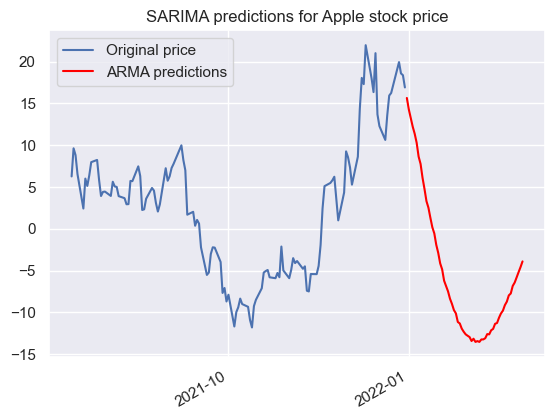

In [9]:
plot_n_days_prior_pred = 2 * forecast_steps

plt.plot(price[-plot_n_days_prior_pred:], label="Original price")
plt.plot(forecast_index, predicted_values, label="ARMA predictions", color="red")
plt.title("SARIMA predictions for Apple stock price")
plt.legend()


# Display limited number of date index
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# Rotate x-axis labels
plt.gcf().autofmt_xdate()

plt.show()

## Train test split

In [10]:
train_test_split_date = pd.Timestamp("2021-10-01")
train, test = (
    price[price.index <= train_test_split_date],
    price[price.index > train_test_split_date],
)

In [11]:
model = SARIMAX(train, order=arima_parameters, seasonal_order=seasonal_order)
result = model.fit()

c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
forecast_steps = len(test)
forecast = result.get_forecast(steps=forecast_steps)
predicted_values = forecast.predicted_mean

c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


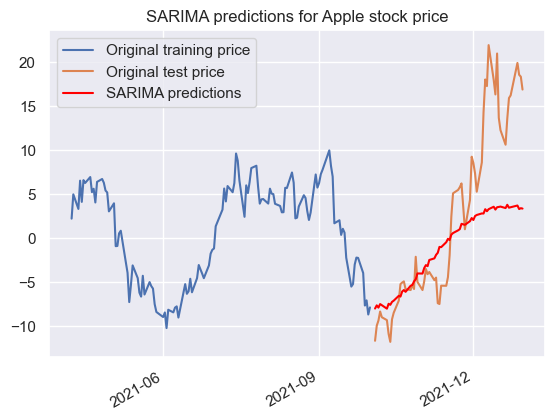

In [13]:
plot_n_days_prior_pred = 2 * forecast_steps

plt.plot(train[-plot_n_days_prior_pred:], label="Original training price")
plt.plot(test, label="Original test price")
plt.plot(test.index, predicted_values, label="SARIMA predictions", color="red")
plt.title("SARIMA predictions for Apple stock price")
plt.legend()


# Display limited number of date index
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# Rotate x-axis labels
plt.gcf().autofmt_xdate()

plt.show()

# Prédiction du prix d'Apple à 2 mois

Recomposons les prédictions du modèle SARIMA pour la stochasticité avec la tendance pour obtenir une prévision du cours d'Apple.

In [14]:
# Import original stock price time series
data_folder = "data/raw"
original_data = pd.read_csv(
    f"{data_folder}/{stock_name}.csv", parse_dates=["Date"], index_col="Date"
)

In [15]:
# Get only close price
original_data = original_data["Close"]

In [16]:
# Train test split
original_data_train, original_data_test = (
    original_data[price.index <= train_test_split_date],
    original_data[price.index > train_test_split_date],
)

In [17]:
# Drop time index in order to vanish weekend days issues
original_data_train.reset_index(drop=True, inplace=True)
original_data_test.reset_index(drop=True, inplace=True)

## Tendance 

On reconstruit la tendance que l'on avait prédite par la méthode de la moyenne mobile.

In [18]:
for i in range(forecast_steps):
    rolling_mean = original_data_train.rolling(window=100, center=False).mean()
    pred_trend = rolling_mean.iloc[-1]
    pred_index = original_data_train.index[-1] + 1
    original_data_train = pd.concat(
        [original_data_train, pd.Series([pred_trend], index=[pred_index])]
    )

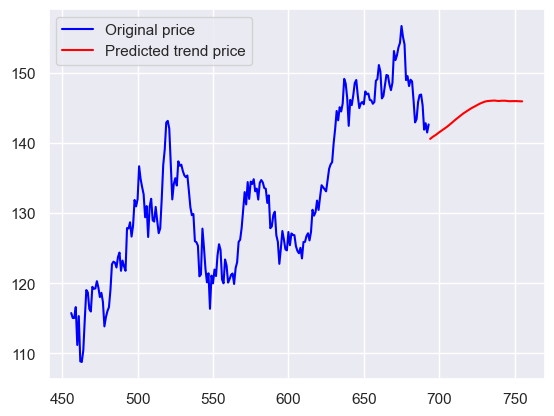

In [19]:
plt.plot(
    original_data_train.iloc[-300:-forecast_steps], color="blue", label="Original price"
)
plt.plot(
    original_data_train.iloc[-forecast_steps:],
    color="red",
    label="Predicted trend price",
)
plt.legend()

## Saisonnalité et stochasticité

In [20]:
# Make SARIMA predicted values begin at zero
predicted_values -= predicted_values.iloc[0]

In [21]:
# Calculate trend + ARIMA
add_components = original_data_train.iloc[-forecast_steps] + predicted_values

# Put predicted data in train series set
original_data_train.iloc[-forecast_steps:] = add_components

## Evaluation de la prédiction

In [22]:
# Set index for test data i.e. actual data
original_data_test.index = original_data_train.index[-forecast_steps:]

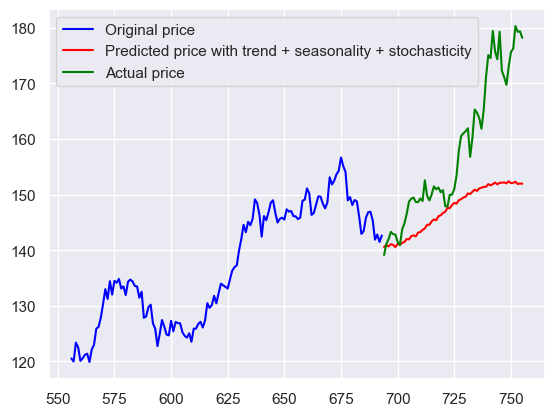

In [23]:
plt.plot(
    original_data_train.iloc[-200:-forecast_steps], color="blue", label="Original price"
)
plt.plot(
    original_data_train.iloc[-forecast_steps:],
    color="red",
    label="Predicted price with trend + seasonality + stochasticity",
)
plt.plot(original_data_test, color="green", label="Actual price")
plt.legend()

In [24]:
y_true = original_data_test
y_pred = original_data_train[-forecast_steps:]

In [25]:
mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)

In [26]:
print(f"{mae = }")
print(f"{rmse = }")


prediction_results_dict["SARIMA"] = [rmse, mae]

mae = 10.685882234235695
rmse = 13.848998606950808


## XGBoost

### Traitement des données

In [27]:
# relecture des données (sans detrend)
data_folder = "data/raw"
stock_name = "AAPL"
df = pd.read_csv(
    f"{data_folder}/{stock_name}.csv", parse_dates=["Date"], index_col="Date"
)
print(f"{df.shape = }")

df.shape = (756, 6)


In [28]:
train_start_date = "2019"
train_end_date = "2021-10-01"
df_train = df.loc[train_start_date:train_end_date].copy()
df_test = df.loc[train_end_date:].copy()

In [29]:
df_train["time_dummy"] = range(len(df_train))
df_test["time_dummy"] = range(len(df_test))
df_test["time_dummy"] += len(df_train)
df_train["day"] = df_train.index.day
df_test["day"] = df_test.index.day

In [30]:
df_train["time_dummy"].tail()

Date
2021-09-27    689
2021-09-28    690
2021-09-29    691
2021-09-30    692
2021-10-01    693
Name: time_dummy, dtype: int64

In [31]:
df_test["time_dummy"].head()

Date
2021-10-01    694
2021-10-04    695
2021-10-05    696
2021-10-06    697
2021-10-07    698
Name: time_dummy, dtype: int64

In [32]:
x_col = ["time_dummy", "day"]
y_col = ["Close"]

In [33]:
x = df_train[x_col]
y = df_train[y_col]

In [34]:
x_test = df_test[x_col]
y_test = df_test[y_col]

### Apprentissage des modèles

In [35]:
lr = LinearRegression()

In [36]:
xgb = xgboost.XGBRegressor(random_state=0, n_jobs=-2, colsample_bytree=0.3, max_depth=3)

In [37]:
lr.fit(x, y)

LinearRegression()

In [38]:
y_residuals = y - lr.predict(x)
xgb.fit(x, y_residuals)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-2,
             num_parallel_tree=None, random_state=0, ...)

In [39]:
def xgb_prediction(xgb: xgboost.XGBRegressor, lr: LinearRegression, x):
    lr_predict = lr.predict(x).reshape(-1, 1)
    y_pred = xgb.predict(x).reshape(-1, 1)

    return y_pred + lr_predict

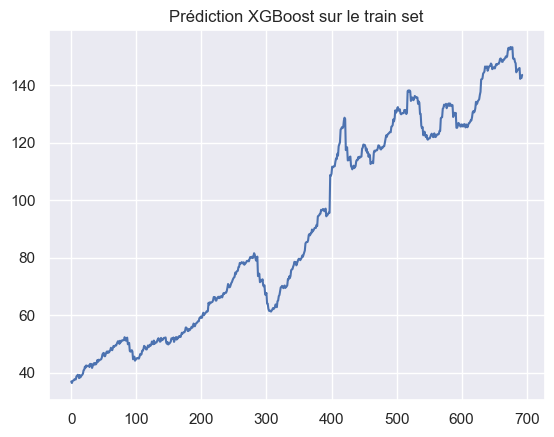

In [40]:
plt.title("Prédiction XGBoost sur le train set")
plt.plot(xgb_prediction(xgb, lr, x))

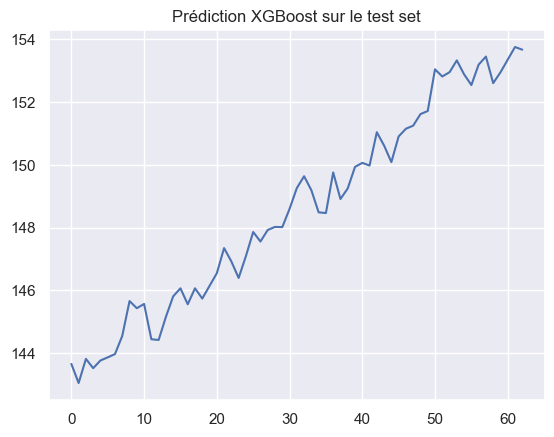

In [41]:
plt.title("Prédiction XGBoost sur le test set")
y_pred = xgb_prediction(xgb, lr, x_test)
plt.plot(y_pred)

In [42]:
y_pred = pd.DataFrame(y_pred)
y_pred.index = df_test.index

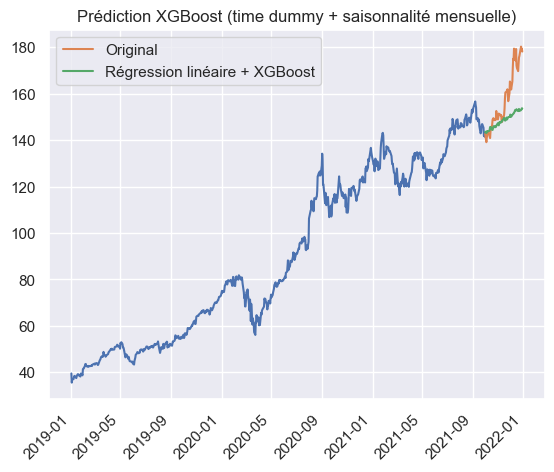

In [43]:
plt.title("Prédiction XGBoost (time dummy + saisonnalité mensuelle)")
plt.plot(df_train[["Close"]])
plt.plot(df_test[["Close"]], label="Original")
plt.plot(y_pred, label="Régression linéaire + XGBoost")
plt.legend()
_ = plt.xticks(rotation=45, ha="right")

In [44]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)


print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

prediction_results_dict["XGBoost"] = [rmse, mae]

RMSE: 13.291437509975168
MAE: 9.85263703644495


## Extra Trees

### Apprentissage des modèles

In [45]:
lr = LinearRegression()

In [46]:
et = ExtraTreesRegressor(random_state=0, n_jobs=-2)

In [47]:
lr.fit(x, y)

LinearRegression()

In [48]:
y_residuals = y - lr.predict(x)
et.fit(x, y_residuals)

c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ExtraTreesRegressor(n_jobs=-2, random_state=0)

In [49]:
def et_prediction(et: ExtraTreesRegressor, lr: LinearRegression, x):
    lr_predict = lr.predict(x).reshape(-1, 1)
    y_pred = et.predict(x).reshape(-1, 1)

    return y_pred + lr_predict

In [50]:
y_pred = et_prediction(et, lr, x_test)
y_pred = pd.DataFrame(y_pred)
y_pred.index = df_test.index

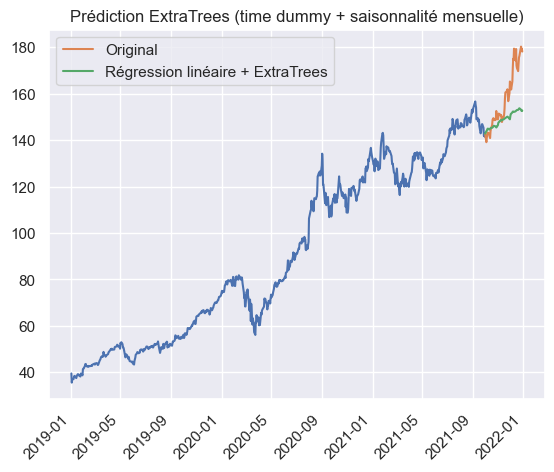

In [51]:
plt.title("Prédiction ExtraTrees (time dummy + saisonnalité mensuelle)")
plt.plot(df_train[["Close"]])
plt.plot(df_test[["Close"]], label="Original")
plt.plot(y_pred, label="Régression linéaire + ExtraTrees")
plt.legend()
_ = plt.xticks(rotation=45, ha="right")

In [52]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)


print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

prediction_results_dict["ExtraTrees"] = [rmse, mae]

RMSE: 13.201822820070818
MAE: 9.74557499696818


## SVM

### Apprentissage des modèles

In [53]:
lr = LinearRegression()

In [54]:
svr = SVR()

In [55]:
lr.fit(x, y)

LinearRegression()

In [56]:
y_residuals = y - lr.predict(x)
svr.fit(x, y_residuals)

c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [57]:
def svr_prediction(svr: SVR, lr: LinearRegression, x):
    lr_predict = lr.predict(x).reshape(-1, 1)
    y_pred = svr.predict(x).reshape(-1, 1)

    return y_pred + lr_predict

In [58]:
y_pred = svr_prediction(svr, lr, x_test)
y_pred = pd.DataFrame(y_pred)
y_pred.index = df_test.index

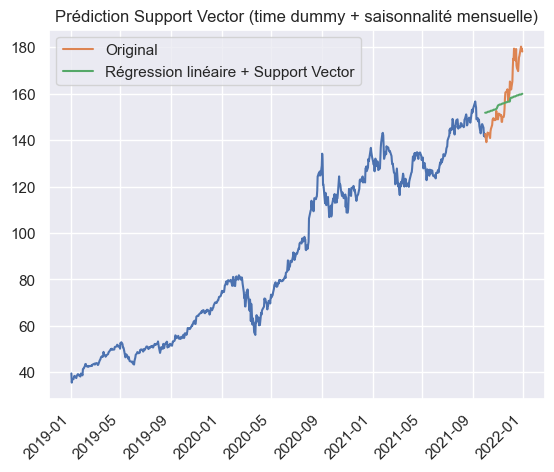

In [59]:
plt.title("Prédiction Support Vector (time dummy + saisonnalité mensuelle)")
plt.plot(df_train[["Close"]])
plt.plot(df_test[["Close"]], label="Original")
plt.plot(y_pred, label="Régression linéaire + Support Vector")
plt.legend()
_ = plt.xticks(rotation=45, ha="right")

In [60]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)


print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

prediction_results_dict["Support Vector Machine"] = [rmse, mae]

RMSE: 10.297525832287155
MAE: 8.73950426028892


## Prophet

### Pré-traitement pour Prophet

In [61]:
# relecture des données (sans detrend)
data_folder = "data/raw"
stock_name = "AAPL"
df = pd.read_csv(
    f"{data_folder}/{stock_name}.csv", parse_dates=["Date"], index_col="Date"
)
print(f"{df.shape = }")

df.shape = (756, 6)


In [62]:
df_train = df.loc[train_start_date:train_end_date]

In [63]:
df_train.shape

(694, 6)

In [64]:
x = df_train[[]].copy()

In [65]:
x["ds"] = df_train.index
x["y"] = df_train[["Close"]]

In [66]:
x.head()

,ds,y
Date,,
2019-01-02,2019-01-02,39.480000
2019-01-03,2019-01-03,35.547501
2019-01-04,2019-01-04,37.064999
2019-01-07,2019-01-07,36.982498
2019-01-08,2019-01-08,37.687500


### Prédiction

#### Calcul de la prédiction

In [67]:
model = Prophet()
model.fit(x)

10:18:48 - cmdstanpy - INFO - Chain [1] start processing
10:18:48 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
future = x_test.copy()
future["ds"] = x_test.index

In [69]:
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
58,2021-12-23,164.084319,158.023536,170.512306
59,2021-12-27,165.483298,159.009757,171.977113
60,2021-12-28,165.809740,159.002697,172.418749
61,2021-12-29,166.157137,159.850301,172.330433
62,2021-12-30,166.183145,159.808016,173.400756


#### Affichage de la prédiction

c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


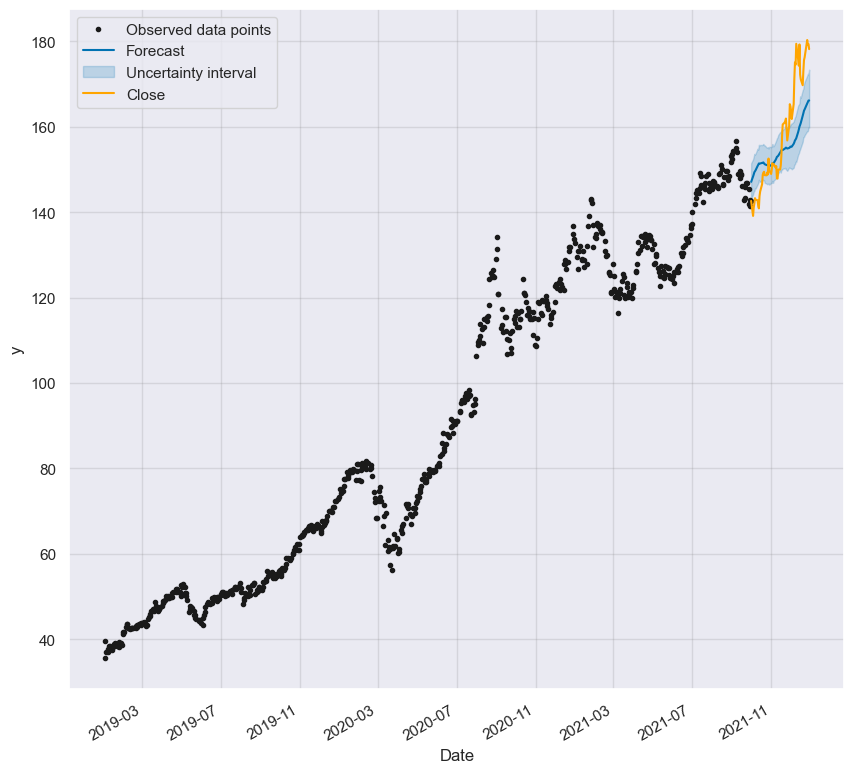

In [70]:
fig, ax1 = plt.subplots(figsize=(10, 10))
fig1 = model.plot(forecast, ax=ax1)
df[["Close"]].loc[train_end_date:].plot(ax=ax1, color="orange")
plt.legend()

### Décomposition

c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\jules\AppData\Local\pypoetry\Cache\virtualenvs\stock-analysis-i8ZI35Fj-py3.10\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of Da

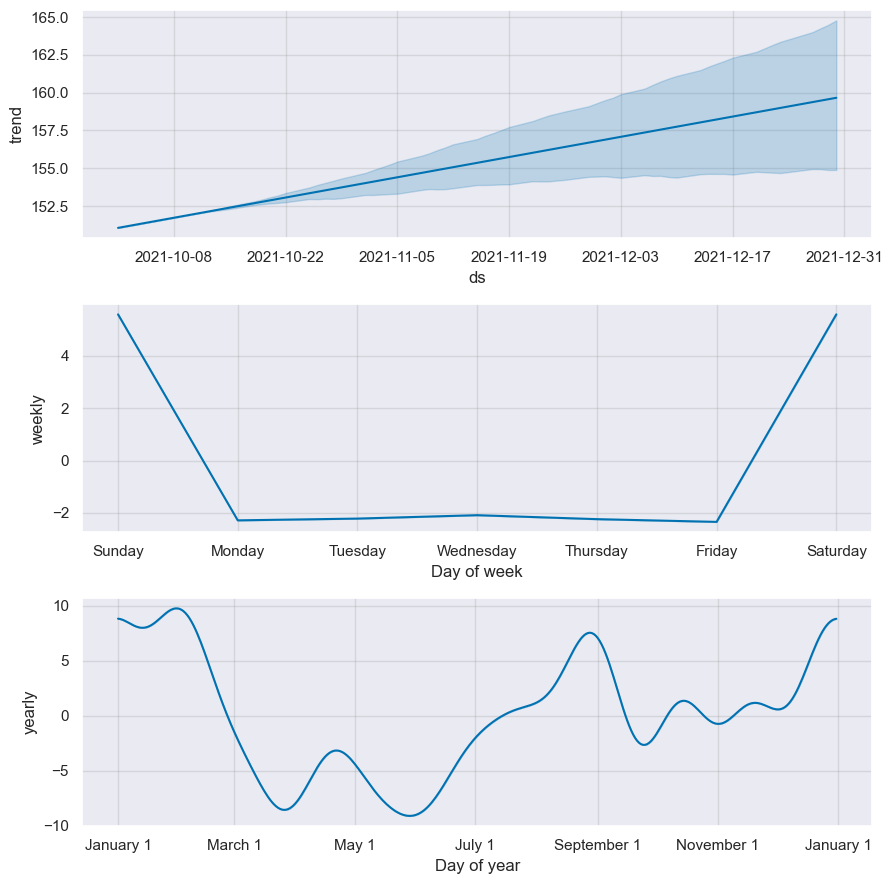

In [71]:
fig2 = model.plot_components(forecast)

### Métriques de prédiction

In [72]:
y_true = df[["Close"]].loc[train_end_date:]
y_pred = forecast[["yhat"]].iloc[-y_true.shape[0] :]

In [73]:
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 8.971550821832377
MAE: 7.262063933618879


In [74]:
prediction_results_dict["Prophet"] = [rmse, mae]

## Comparaison des modèles

In [80]:
prediction_results_df = pd.DataFrame(prediction_results_dict).T
prediction_results_df.columns = ["RMSE", "MAE"]
# prediction_results_df

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'XGBoost'),
  Text(1, 0, 'ExtraTrees'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Prophet'),
  Text(4, 0, 'SARIMA')])

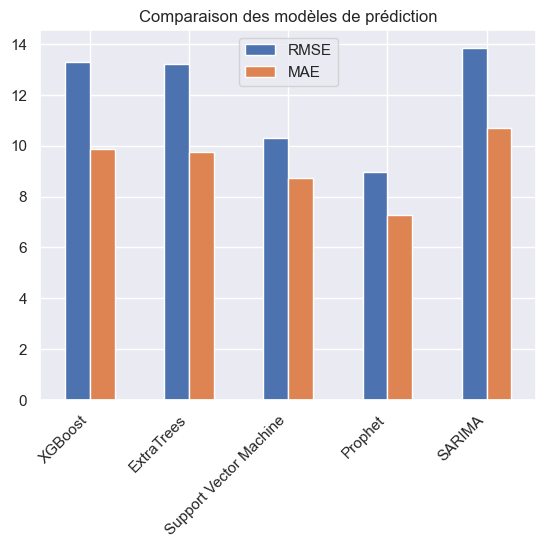

In [81]:
prediction_results_df.plot(kind="bar")
plt.title("Comparaison des modèles de prédiction")

plt.xticks(rotation=45, ha="right")

In [77]:
# print(prediction_results_df.to_markdown())

**Tableau.** Comparaison des modèles de prédiction

|                        |        RMSE |         MAE | Graphiquement |
|:-----------------------|------------:|------------:|:-------------:|
| ARMA                   |     17.3524 |     14.9797 |       ✅       |
| SARIMA                 |     13.6817 |     11.6047 |       ✅       |
| XGBoost                |     13.2914 |     9.85264 |       ✅       |
| ExtraTrees             |     13.2018 |     9.74557 |       ✅       |
| Support Vector Machine |     10.2975 |      8.7395 |       ❌       |
| **Prophet**            | **8.97155** | **7.26206** |       ✅       |

Meilleur modèle : Prophet